In [20]:
import numpy             as np
import gvar              as gv
import matplotlib.pyplot as plt
import lsqfit
import itertools
from tqdm import tqdm

In [21]:
from b2heavy.FnalHISQMetadata import params as mData

In [22]:
from b2heavy.ThreePointFunctions.types3pts  import Ratio, RatioIO, ratio_prerequisites
from b2heavy.ThreePointFunctions.fitter3pts import RatioFitter, phys_energy_priors
from b2heavy.ThreePointFunctions.utils      import read_config_fit, dump_fit_object

In [23]:
DATA_DIR = '/Users/pietro/code/data_analysis/BtoD/Alex/'
DATA_2PT = '/Users/pietro/code/data_analysis/data/QCDNf2p1stag/B2heavy/report'

BINSIZE  = {
    'MediumCoarse':13,
    'Coarse-2':    16,
    'Coarse-1':    11,
    'Coarse-Phys': 19,
    'Fine-1':      16,
    'Fine-Phys':   16,
    'SuperFine':   22
}

In [24]:
ENSEMBLE = 'Coarse-Phys'
RATIO    = 'QPLUS'
MOMENTUM = '100'

# SMSLIST  = ['1S','RW']
SMSLIST  = ['1S', 'RW']

In [25]:
# Correlation matrix specifics
DIAG   = False
BLOCK  = False
SCALE  = True
SHRINK = True
SVD    = 1E-12

In [26]:
# Specifics of the analysis
TMIN    = 1
NSTATES = 2
WPRIORS = True
JKFIT   = False

In the following we look for requisites for the ratio calculation

In [27]:
requisites = ratio_prerequisites(
    ens      = ENSEMBLE,
    ratio    = RATIO,
    mom      = MOMENTUM,
    readfrom = DATA_2PT,
    jk       = JKFIT
)

requisites

{'E0': 1.0078553977756999,
 'm0': 0.9998950589461969,
 'Z0': {'1S': 2.45951731300508, 'd': 0.31293272782761744},
 'Zpar': None,
 'Zbot': None,
 'Zp': {'1S': 2.401489249186158, 'd': 0.31306106360711355},
 'wrecoil': None,
 'jk': False}

Here we initialize the master object that contains a ratio at given momentum for a given ensemble

In [28]:
io = RatioIO(ENSEMBLE,RATIO,MOMENTUM,PathToDataDir=DATA_DIR)
robj = RatioFitter(
    io,
    jkBin     = BINSIZE[ENSEMBLE],
    smearing  = SMSLIST,
    readfrom  = DATA_2PT,
    **requisites
)

In [29]:
trange = (TMIN, robj.Ta-TMIN)

Here we elaborate the optimal $\epsilon$ cut for correlation matrix

In [30]:
cov_specs = dict(
    diag   = DIAG  ,
    block  = BLOCK ,
    scale  = SCALE ,
    shrink = SHRINK,
    # cutsvd = find_eps_cut(robj,trange)
    cutsvd = 1E-12
)

cov_specs

{'diag': False, 'block': False, 'scale': True, 'shrink': True, 'cutsvd': 1e-12}

Here we compute fit priors

In [31]:
dE_src = phys_energy_priors(ENSEMBLE,'D',MOMENTUM,NSTATES,readfrom=DATA_2PT,error=0.5)
dE_snk = phys_energy_priors(ENSEMBLE,'B'  ,MOMENTUM,NSTATES,readfrom=DATA_2PT,error=0.5)

pr = robj.priors(NSTATES, dE_src=dE_src, dE_snk=dE_snk)
pr

{'ratio': [0.99(10)],
 'A_1S': [0 ± 1.0, 0 ± 1.0],
 'B_1S': [0 ± 1.0, 0 ± 1.0],
 'A_RW': [0 ± 1.0, 0 ± 1.0],
 'B_RW': [0 ± 1.0, 0 ± 1.0],
 'dE_src': [-0.74(50), -0.26(50)],
 'dE_snk': [-0.91(50), -0.52(50)]}

In [32]:
robj.priors(NSTATES)

{'ratio': [0.99(10)],
 'A_1S': [0 ± 1.0, 0 ± 1.0],
 'B_1S': [0 ± 1.0, 0 ± 1.0],
 'A_RW': [0 ± 1.0, 0 ± 1.0],
 'B_RW': [0 ± 1.0, 0 ± 1.0],
 'dE_src': [-1.5(1.0), -1.5(1.0)],
 'dE_snk': [-1.5(1.0), -1.5(1.0)]}

Here we perform the fit

In [33]:
fit = robj.fit(
    Nstates = NSTATES,
    trange  = trange,
    priors  = robj.priors(NSTATES,**pr),
    verbose = False,
    **cov_specs,
)

res = robj.fit_result(
    Nexc   = NSTATES,
    trange = trange,
    verbose = True,
    priors = pr 
)

# ---------- chi^2_exp analysis -------------
# chi2_exp = 22.000000000004867 +/- 6.633249580710691 
# p-value [eval] = 0.4488
# p-value [MC]   = 0.4546
# ---------- 2+2 fit in (1, 11) for mes: QPLUS of ens: Coarse-Phys for mom: 100 --------------
Least Square Fit:
  chi2/dof [dof] = 1 [22]    Q = 0.45    logGBF = 98.124

Parameters:
        ratio 0    0.9954 (28)      [  0.99 (10) ]  
         A_1S 0   -0.0134 (71)      [    0 ± 1.0 ]  
              1   -0.0034 (65)      [    0 ± 1.0 ]  
         B_1S 0      0.21 (64)      [    0 ± 1.0 ]  
              1     -0.21 (64)      [    0 ± 1.0 ]  
         A_RW 0   -0.0007 (55)      [    0 ± 1.0 ]  
              1    0.0013 (40)      [    0 ± 1.0 ]  
         B_RW 0     0.019 (68)      [    0 ± 1.0 ]  
              1    -0.014 (69)      [    0 ± 1.0 ]  
       dE_src 0     -1.19 (42)      [ -0.74 (50) ]  
              1     -0.16 (48)      [ -0.26 (50) ]  
       dE_snk 0     -1.27 (25)      [ -0.91 (50) ]  
              1     -1.37 (2

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


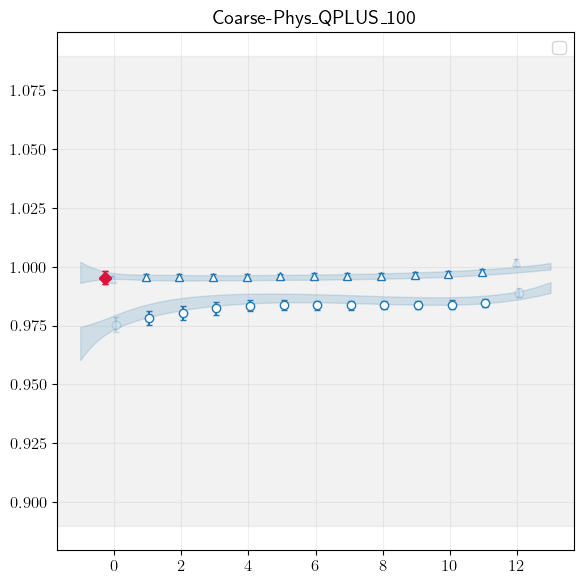

In [34]:
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 12

# f, ax = plt.subplots(1,1,figsize=(8,4))
f, ax = plt.subplots(1,1,figsize=(6,6))

robj.plot_fit(ax,NSTATES,trange)

f0 = pr['ratio'][0]
ax.axhspan(ymin=f0.mean-f0.sdev,ymax=f0.mean+f0.sdev,alpha=0.1,color='gray')

# ax.set_xlim(-0.5,18)
ax.grid(alpha=0.2)
ax.legend()
ax.set_title(f'{ENSEMBLE}_{RATIO}_{MOMENTUM}')
plt.tight_layout()
# plt.savefig('/Users/pietro/Desktop/bad_ratio.pdf')

# Model average for `Nstates` and trange

In [35]:
TIC = {}
pval = {}
for Nstates in [1,2,3]:
    dE_src = phys_energy_priors(ENSEMBLE,'Dst',MOMENTUM,Nstates,readfrom=DATA_2PT)
    dE_snk = phys_energy_priors(ENSEMBLE,'B'  ,MOMENTUM,Nstates,readfrom=DATA_2PT)
    x,ydata = robj.format(trange,flatten=True)
    f_0    = gv.gvar(np.mean(ydata).mean,0.05)
    pr = robj.priors(Nstates, K=f_0, dE_src=dE_src, dE_snk=dE_snk)

    for tmin in [1,2,3,4]:
        print(f'{Nstates=},{tmin=}')

        trange = (tmin, robj.Ta-tmin-1)

        fit = robj.fit(
            Nstates = Nstates,
            trange  = trange,
            priors  = pr,
            verbose = False,
            **cov_specs
        )

        res = robj.fit_result(
            Nexc   = Nstates,
            trange = trange,
            priors = pr,
            verbose = False
        )
        TIC[Nstates,trange] = float((res['chi2aug'] - 2*res['chiexp']))
        pval[Nstates,trange] = res['pstd']

Nstates=1,tmin=1
# ---------- chi^2_exp analysis -------------
# chi2_exp = 20.000000000000725 +/- 6.32455532033659 
# p-value [eval] = 0.2898
# p-value [MC]   = 0.28979999999999995
Nstates=1,tmin=2
# ---------- chi^2_exp analysis -------------
# chi2_exp = 15.999999999999899 +/- 5.656854249492332 
# p-value [eval] = 0.5531
# p-value [MC]   = 0.5581
Nstates=1,tmin=3
# ---------- chi^2_exp analysis -------------
# chi2_exp = 12.000000000000153 +/- 4.89897948556635 
# p-value [eval] = 0.3741
# p-value [MC]   = 0.37670000000000003
Nstates=1,tmin=4
# ---------- chi^2_exp analysis -------------
# chi2_exp = 8.000000000000147 +/- 4.00000000000003 
# p-value [eval] = 0.6992
# p-value [MC]   = 0.6991
Nstates=2,tmin=1
# ---------- chi^2_exp analysis -------------
# chi2_exp = 19.99999999999968 +/- 6.324555320336248 
# p-value [eval] = 0.7631
# p-value [MC]   = 0.764
Nstates=2,tmin=2
# ---------- chi^2_exp analysis -------------
# chi2_exp = 15.999999999999101 +/- 5.656854249492329 
# p-value [e

In [39]:
TIC

{(1, (1, 10)): -17.150014373925508,
 (1, (2, 9)): -17.438172982631006,
 (1, (3, 8)): -11.113150657572037,
 (1, (4, 7)): -10.432256667572435,
 (2, (1, 10)): -24.79341678182741,
 (2, (2, 9)): -18.57412053921475,
 (2, (3, 8)): -21.898179068601674,
 (2, (4, 7)): -15.783073749584357,
 (3, (1, 10)): -28.53960101216539,
 (3, (2, 9)): -28.635474678796445,
 (3, (3, 8)): -22.548759508621515,
 (3, (4, 7)): -15.954302448728498}

In [38]:
norm = np.exp(-np.array(list(TIC.values()))/2).sum()

vals = np.array([f.p['ratio'][0] for k,f in robj.fits.items()])
weig = np.array([np.exp(-TIC[k]/2)/norm for k in robj.fits]   )

stat = sum(vals * weig)
syst = np.sqrt(gv.mean(sum(weig*vals*vals) - (sum(weig*vals))**2))


print(stat,syst)

KeyError: (2, (1, 11))

Print the results

NameError: name 'stat' is not defined

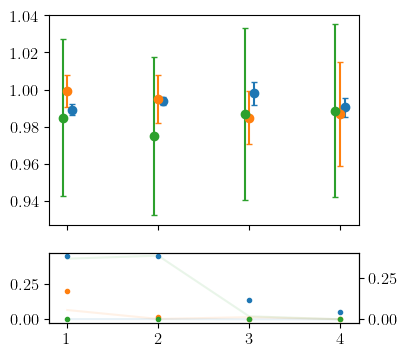

In [37]:
f, ax = plt.subplots(2,1,figsize=(4,4),gridspec_kw={'height_ratios': [3, 1]},sharex=True)

ts      = np.array([1,2,3,4])
tranges = [((t,robj.Ta-t-1)) for t in ts]

ax2 = ax[1].twinx()

for i,n in enumerate([1,2,3]):
    f0 = [robj.fits[n,tr].p['ratio'][0] for tr in tranges]
    off = -0.05*i + 0.05
    ax[0].errorbar(ts+off,gv.mean(f0),gv.sdev(f0),fmt='o', color=f'C{i}', capsize=2.5, label=f'({n+1}+{n+1})')

    tic = [np.exp(-TIC[n,tr]/2)/norm for tr in tranges]
    ax[1].plot(ts,tic,alpha=0.1,color=f'C{i}')
    # ax[1].scatter(ts,tic,marker='o',color=f'C{i}')

    pv = [pval[n,tr] for tr in tranges]
    ax2.scatter(ts,pv,color=f'C{i}',marker='.')


ax[0].axhspan(ymin=stat.mean-stat.sdev,ymax=stat.mean+stat.sdev,color='gray',alpha=0.2,label='model average')
err = np.sqrt(stat.sdev**2+syst**2)
ax[0].axhline(stat.mean-err,color='gray',alpha=0.2,linestyle=':')
ax[0].axhline(stat.mean+err,color='gray',alpha=0.2,linestyle=':')

ax[0].grid(alpha=0.2)
ax[0].legend(loc='lower right')
ax[0].set_ylabel(r'$F_0$')

ax[1].grid(alpha=0.2)
# ax[1].set_ylim(-0.1,1.1)
ax[1].set_ylabel(r'TIC weight')
ax[1].set_xlabel(r'$\frac{t_{min}}{a}$')

ax2.set_ylabel(r'$p$-value')

ax[0].set_title(f'{ENSEMBLE}_{RATIO}')

plt.tight_layout()
plt.savefig(f'/Users/pietro/Desktop/model_average_{ENSEMBLE}_{RATIO}_{MOMENTUM}.pdf')